In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):

    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, n_groups=50, group_train_size=30, group_test_size=6, group_gap=2, verbose=False):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.n_groups = n_groups
        self.group_train_size = group_train_size
        self.group_test_size = group_test_size
        self.group_gap = group_gap
        self.verbose = verbose
    
    def split(self, X, y=None):
        n_groups = self.n_groups
        group_train_size = self.group_train_size
        group_test_size = self.group_test_size
        group_gap = self.group_gap

        X, y = indexable(X, y)
        n_samples = _num_samples(X)
        n_splits = self.n_splits

        assert (group_train_size + group_gap + group_test_size + self.n_splits*1) <= n_groups, \
                "The group nums of test and train set is not sensible"

        group_dict = {}
        groups = np.sort(np.array(list(range(n_groups))*np.ceil(n_samples/n_groups).astype('int'))[:n_samples])
        unique_groups, ind = np.unique(groups, return_index=True)

        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        
        group_slip = int((n_groups - (group_train_size + group_gap + group_test_size))/(n_splits-1))
        group_train_starts = range(0, n_splits*group_slip, group_slip)

        splits = 1
        for group_train_start in group_train_starts:
            train_array = []
            test_array = []

            for i in range(group_train_start, group_train_start+group_train_size):
                train_array += group_dict[i]
            for i in range(group_train_start+group_train_size+group_gap, group_train_start+group_train_size+group_gap+group_test_size):
                test_array += group_dict[i]
            
            if splits == n_splits:
                for j in range(i,n_groups):
                    test_array += group_dict[j]

            if self.verbose > 0:
                pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]
            splits += 1

In [3]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, ax, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    n_splits = cv.n_splits
    n_groups = cv.n_groups

    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    groups = np.sort(np.array(list(range(n_groups))*np.ceil(len(X)/n_groups).astype('int'))[:len(X)])
    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=groups, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

/tmp/ipykernel_275925/1554176855.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('jet', 256)


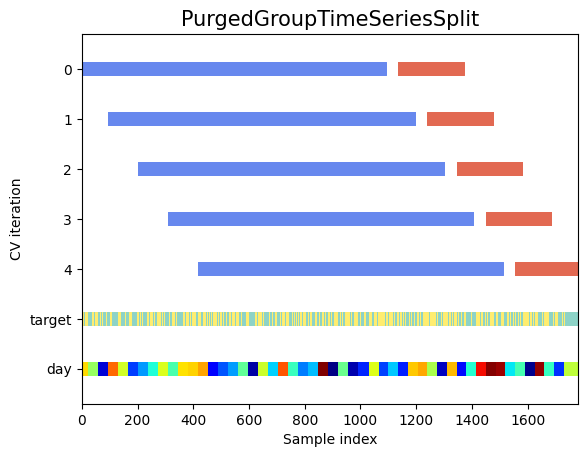

In [5]:
def main():
    x = np.random.random(size=(1780,5))
    y = np.random.choice((0,1),size=(1780,))

    fig, ax = plt.subplots()
    cv = PurgedGroupTimeSeriesSplit(n_groups=50,group_train_size=30,group_test_size=6,group_gap=2)
    plot_cv_indices(cv, x, y, ax)

if __name__ == '__main__':
    main()